In [1]:
# sytem lib
import os

import matplotlib.pyplot as plt

# common lib
import numpy as np
import segmentation_models_pytorch as smp

# torh lib
import torch
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

DATA_DIR = './dataset'

# determine the device to be used for training and evaluation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == 'cuda' else False

load_dotenv()

True

### Utilities

In [2]:
# helper function for data visualization


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# 1. Data

## 1.1 Download data

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

FILE_ID = os.getenv('FILE_ID')

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.makedirs(DATA_DIR)
    dest_path = os.path.join(DATA_DIR, 'dataset.zip')
    gdd.download_file_from_google_drive(
        file_id=FILE_ID,
        dest_path=dest_path,
        unzip=True,
    )
    print('Done!')

## 1.2 Define dataset

In [4]:
import cv2
from torch.utils.data import Dataset


class MedPatDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, preprocessing, augmentation):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        class_label = float(np.sum(mask) > 0)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

        # check to see if we are applying any transformations
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # return a tuple of the image and its mask
        return (image, mask, class_label)

## 1.3 Split to train and test

In [5]:
TEST_SPLIT = 0.2


def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]


imagePaths = list_full_paths(os.path.join(DATA_DIR, 'images'))
maskPaths = list_full_paths(os.path.join(DATA_DIR, 'masks'))

train_img, test_img, train_masks, test_masks = train_test_split(
    imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42
)
print(f'Train size = {len(train_img)}')
print(f'Test size = {len(test_img)}')


Train size = 160
Test size = 40


Image and mask for class 0.0


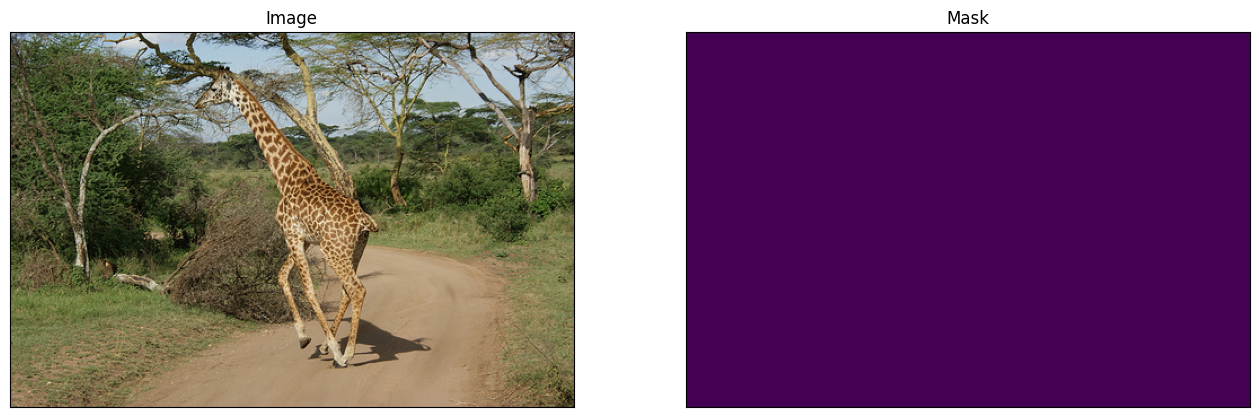

In [6]:
# just look on raw data
train_dataset = MedPatDataset(train_img, train_masks, None, None)
test_dataset = MedPatDataset(test_img, test_masks, None, None)

image, mask, class_label = train_dataset[1]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

Image and mask for class 1.0


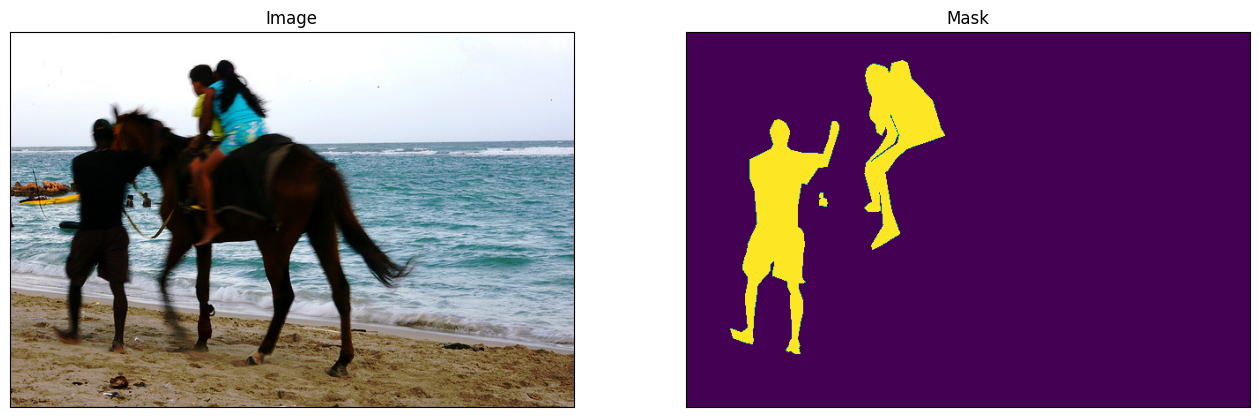

In [7]:
image, mask, class_label = train_dataset[10]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

## 1.4 Check class balance

In [8]:
train_class_1 = 0
for images, gt_masks, class_label in train_dataset:
    if class_label == 1:
        train_class_1 += 1
test_class_1 = 0
for images, gt_masks, class_label in test_dataset:
    if class_label == 1:
        test_class_1 += 1
print(
    f'proportion of positive class in train data {train_class_1/len(train_dataset):.4f}'
)
print(
    f'proportion of positive class in test data {test_class_1/len(test_dataset):.4f}'
)


proportion of positive class in train data 0.4875
proportion of positive class in test data 0.5500


## 1.5 Preprocessing and Augmentations

In [9]:
# convert input data to encoder needs format
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [10]:
import albumentations as albu

IMAGE_SIZE = 256


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        albu.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True
        ),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    import torchvision.transforms as transforms

    transform = transforms.Compose([transforms.ToTensor()])

    return transform(x)


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


image, mask, cls = train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,
    augmentation=None,
)[0]
conv_img = preprocessing_fn(image)
conv_mask = preprocessing_fn(mask)
v = 1

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Image and mask for class 1.0


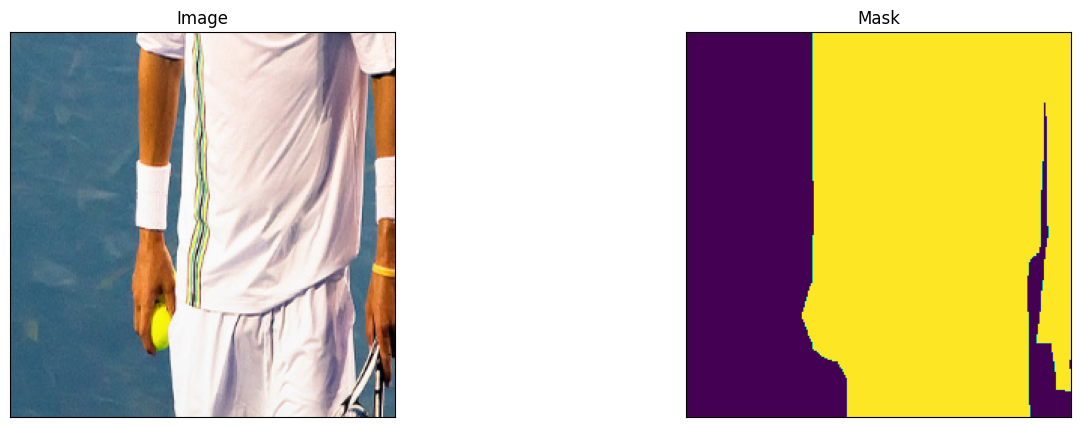

Image and mask for class 0.0


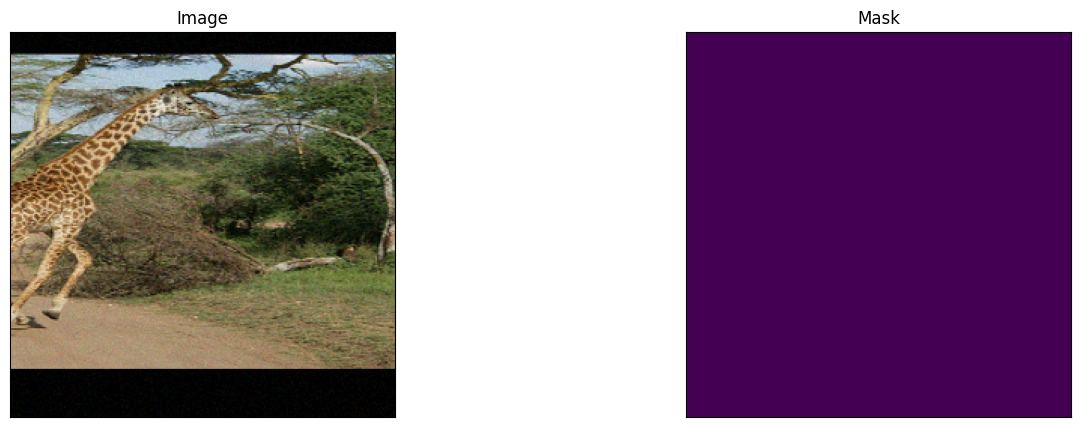

Image and mask for class 0.0


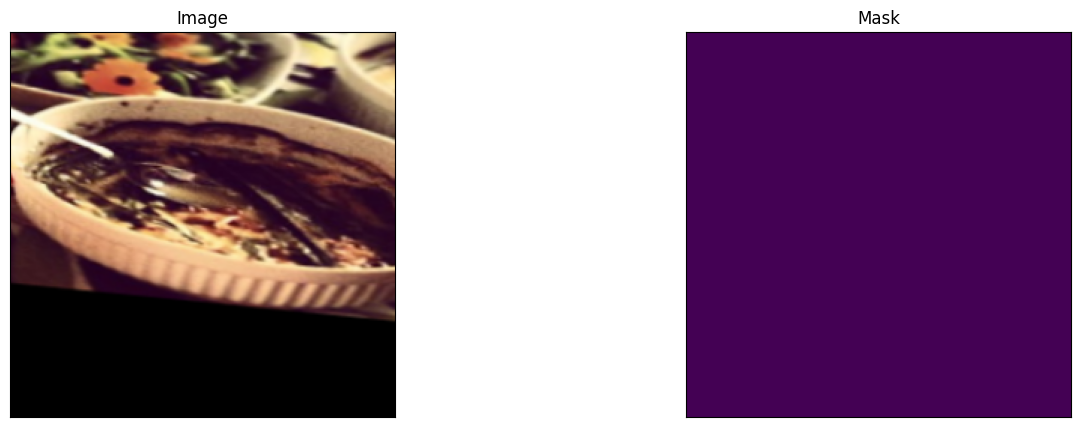

Image and mask for class 0.0


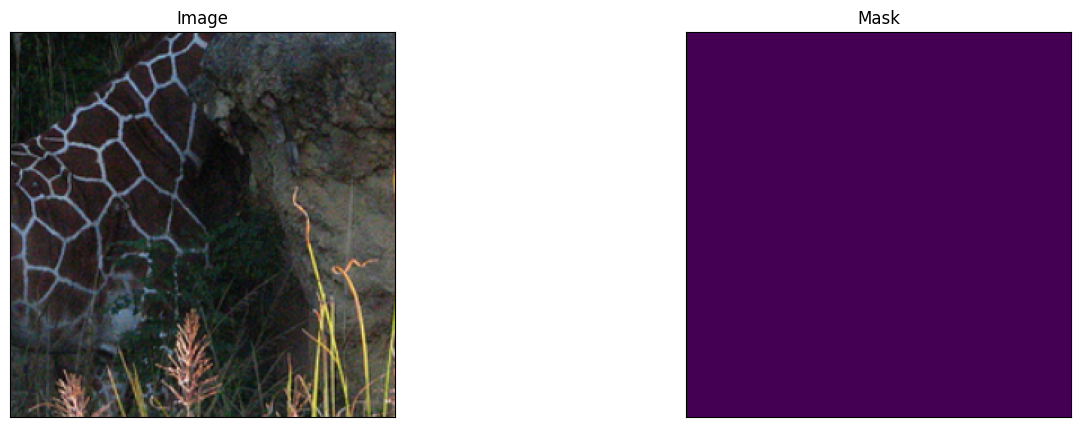

Image and mask for class 1.0


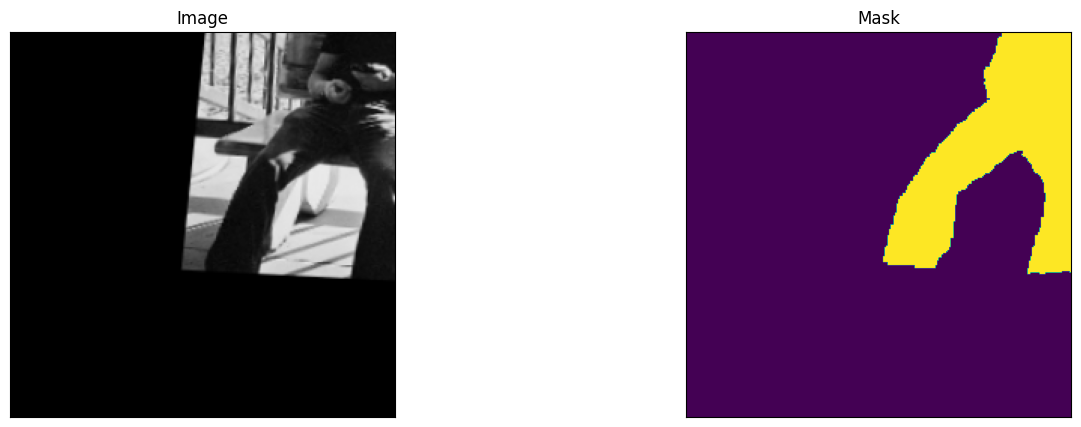

Image and mask for class 1.0


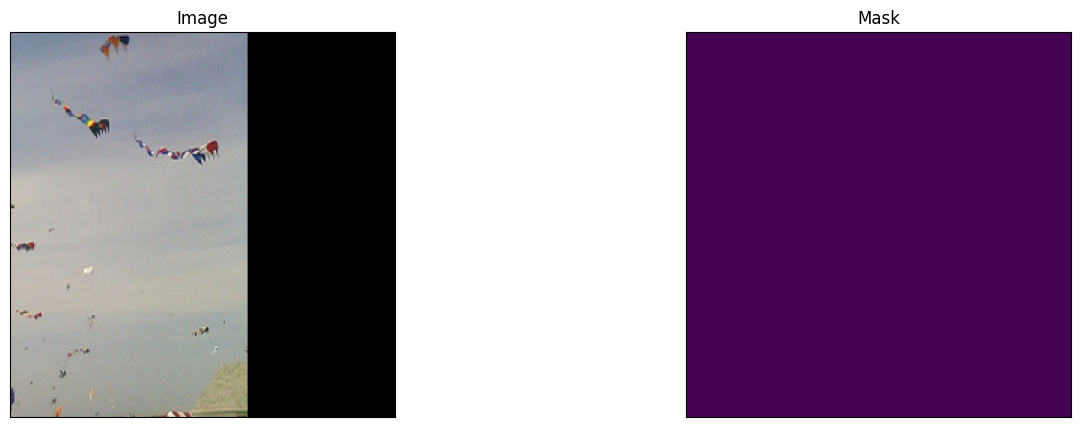

Image and mask for class 1.0


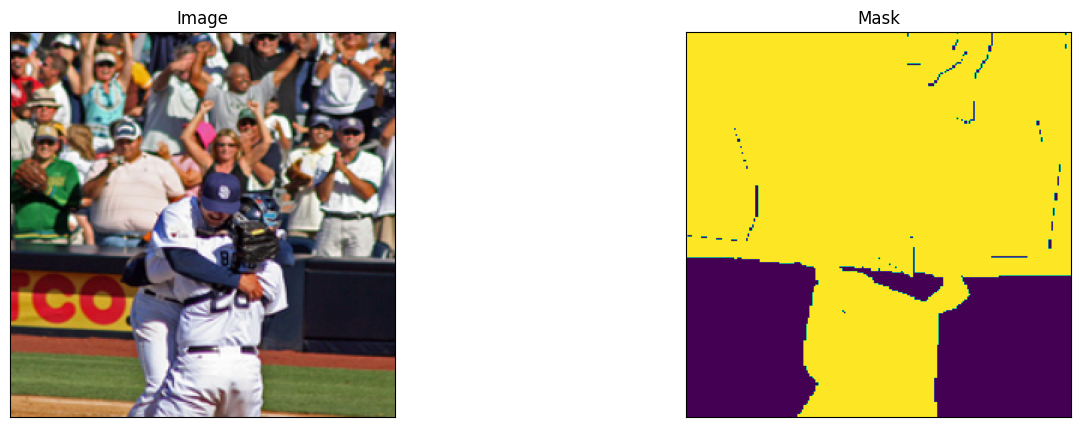

Image and mask for class 0.0


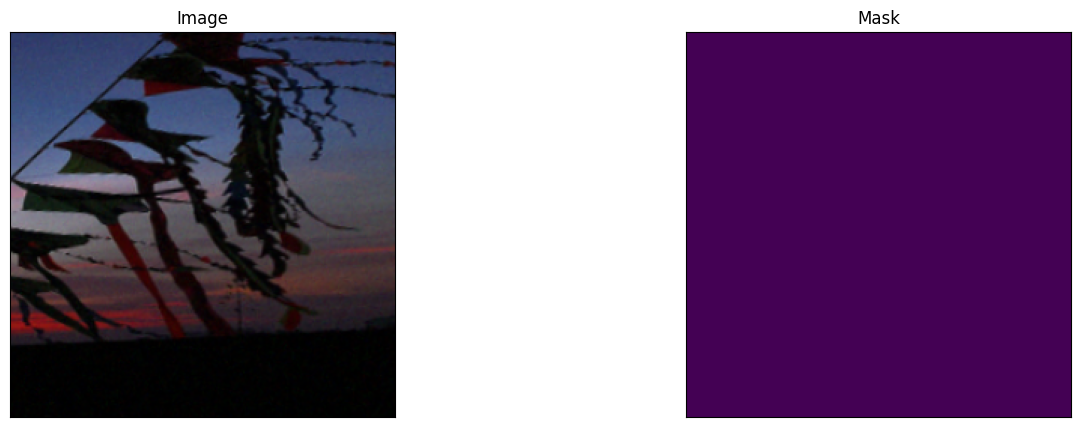

Image and mask for class 1.0


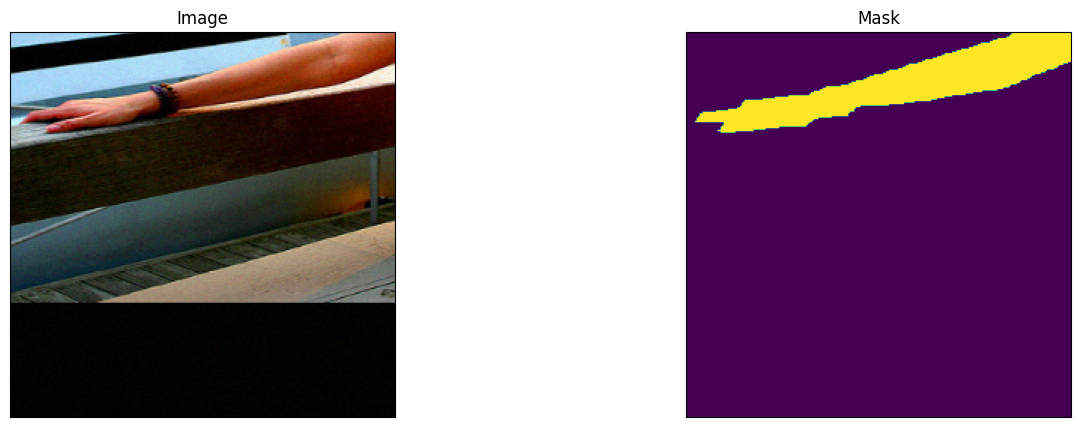

Image and mask for class 1.0


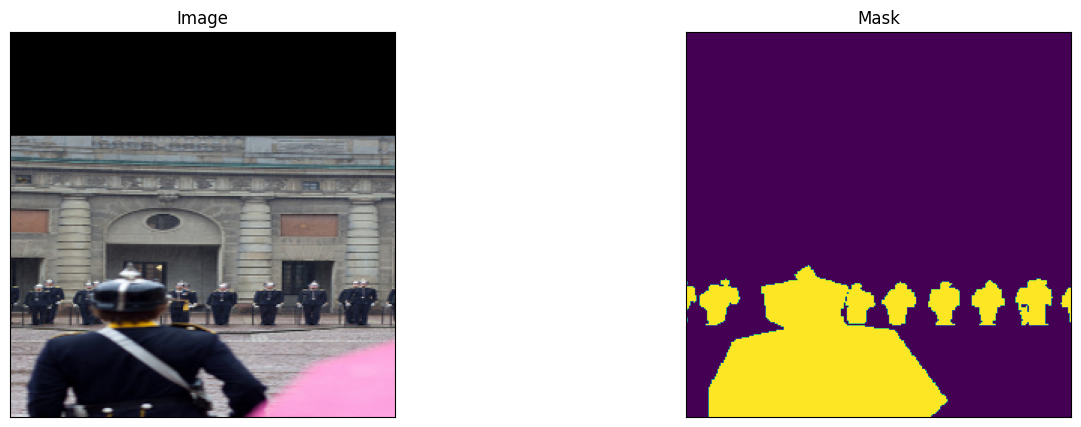

In [11]:
# visual check  work of augmentation
train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,  # get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=None,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(5):
    image, mask, class_label = train_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# same image with different random transforms
for i in range(5):
    image, mask, class_label = test_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# 2. Define and train model

In [12]:
CLASSES = ['human']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation

aux_params = dict(
    pooling='avg',  # one of 'avg', 'max'
    dropout=0.5,  # dropout ratio, default is None
    classes=1,  # define number of output labels
    activation='sigmoid',
)

# create segmentation model with pretrained encoder
unet = smp.Unet(
    encoder_name=ENCODER,
    # encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    aux_params=aux_params,
).to(DEVICE)

In [13]:
unet

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
unet.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [15]:
# architecture of the neural network of the classifier. The output from the encoder is input to this classifier
unet.classification_head

ClassificationHead(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.5, inplace=True)
  (3): Linear(in_features=512, out_features=1, bias=True)
  (4): Activation(
    (activation): Sigmoid()
  )
)

In [16]:
INIT_LR = 0.001

# cross_entropy = nn.CrossEntropyLoss()
BCE = nn.BCEWithLogitsLoss()
DICE = smp.losses.DiceLoss(mode='binary')
opt_seg = Adam(
    [
        {'params': unet.encoder.parameters()},
        {'params': unet.decoder.parameters()},
        {'params': unet.segmentation_head.parameters()},
    ],
    lr=INIT_LR,
)
opt_cls = Adam([{'params': unet.classification_head.parameters()}], lr=INIT_LR)


def metrics(y_pred, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }


In [17]:
import warnings

from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

BATCH_SIZE = 16
NUM_EPOCHS = 200

train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY
)

print('[INFO] training the network...')
# history log
H = {
    'train_loss': [],
    'train_loss_seg': [],
    'train_loss_cls': [],
    'test_loss': [],
    'recall': [],
    'accuracy': [],
    'precision': [],
}
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    # initialize the total training and validation loss
    train_loss = 0
    train_loss_seg = 0
    train_loss_cls = 0
    test_loss = 0
    recall = 0
    accuracy = 0
    precision = 0
    train_steps = 0
    test_steps = 0

    for images, gt_masks, class_label in train_loader:
        train_steps += 1

        (images, gt_masks, class_label) = (
            images.to(DEVICE, dtype=torch.float),
            gt_masks.to(DEVICE),
            class_label.to(DEVICE),
        )
        predicted_mask, _ = unet(images)

        loss_seg = BCE(predicted_mask, gt_masks)

        opt_seg.zero_grad()
        loss_seg.backward()
        opt_seg.step()

        _, labels = unet(images)

        loss_cls = BCE(labels, class_label.unsqueeze(1))

        opt_cls.zero_grad()
        loss_cls.backward()
        opt_cls.step()

        loss = loss_seg + loss_cls

        train_loss += loss
        train_loss_seg += loss_seg
        train_loss_cls += loss_cls

    # set the model in evaluation mode
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        for images, gt_masks, class_label in test_loader:
            test_steps += 1
            (images, gt_masks, class_label) = (
                images.to(DEVICE, dtype=torch.float),
                gt_masks.to(DEVICE),
                class_label.to(DEVICE),
            )
            predicted_mask, labels = unet(images)

            loss_test = BCE(predicted_mask, gt_masks)
            +BCE(labels, class_label.unsqueeze(1))
            test_loss += loss_test

            # metric calc
            y_pred = labels.view(-1).cpu().detach().numpy().round()
            y_true = class_label.view(-1).cpu().detach().numpy()
            batch_metircs = metrics(y_pred, y_true)
            precision += batch_metircs['precision']
            accuracy += batch_metircs['accuracy']
            recall += batch_metircs['recall']

            if e > 1 and e % 10 == 0:
                torch.save(unet, 'unet_medpat.pt')

    # calculate the average training and test loss
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    avg_loss_seg = train_loss_seg / train_steps
    avg_loss_cls = train_loss_cls / train_steps
    avg_recall = recall / test_steps
    avg_precision = precision / test_steps
    avg_accuracy = accuracy / test_steps
    H['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    H['train_loss_seg'].append(avg_loss_seg.cpu().detach().numpy())
    H['train_loss_cls'].append(avg_loss_cls.cpu().detach().numpy())
    H['test_loss'].append(avg_test_loss.cpu().detach().numpy())
    H['recall'].append(avg_recall)
    H['precision'].append(avg_precision)
    H['accuracy'].append(avg_accuracy)

    torch.save(unet, 'unet_medpat.pt')

    print(f'[INFO] EPOCH: {e+1}/{NUM_EPOCHS}')
    print(f'Train loss: {avg_train_loss:.6f}, test loss {avg_test_loss:.6f}')
    if e % 10 == 0:
        print(
            f'Train loss seg: {avg_loss_seg:.6f}, train loss cls {avg_loss_cls:.6f}'
        )
        print(
            f'EPOCH metrics: accuracy {avg_accuracy:.4f}, recall {avg_recall:.4f}, precision {avg_precision:.4f}'
        )


[INFO] training the network...


  0%|          | 1/200 [01:23<4:36:38, 83.41s/it]

[INFO] EPOCH: 1/200
Train loss: 1.389917, test loss 1.219083
Train loss seg: 0.661561, train loss cls 0.728356
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


  1%|          | 2/200 [02:36<4:15:08, 77.32s/it]

[INFO] EPOCH: 2/200
Train loss: 1.151248, test loss 2.330472


  2%|▏         | 3/200 [03:52<4:11:13, 76.51s/it]

[INFO] EPOCH: 3/200
Train loss: 1.053080, test loss 0.498767


  2%|▏         | 4/200 [05:08<4:10:09, 76.58s/it]

[INFO] EPOCH: 4/200
Train loss: 1.004971, test loss 0.395762


  2%|▎         | 5/200 [06:25<4:09:40, 76.82s/it]

[INFO] EPOCH: 5/200
Train loss: 0.994611, test loss 0.439593


  3%|▎         | 6/200 [07:43<4:09:20, 77.11s/it]

[INFO] EPOCH: 6/200
Train loss: 0.977096, test loss 0.400588


  4%|▎         | 7/200 [08:56<4:03:56, 75.83s/it]

[INFO] EPOCH: 7/200
Train loss: 0.951575, test loss 0.391188


  4%|▍         | 8/200 [10:17<4:07:49, 77.45s/it]

[INFO] EPOCH: 8/200
Train loss: 0.942627, test loss 0.376403


  4%|▍         | 9/200 [11:40<4:12:18, 79.26s/it]

[INFO] EPOCH: 9/200
Train loss: 0.961730, test loss 0.461610


  5%|▌         | 10/200 [12:59<4:10:38, 79.15s/it]

[INFO] EPOCH: 10/200
Train loss: 0.941584, test loss 0.393451


  6%|▌         | 11/200 [14:18<4:09:17, 79.14s/it]

[INFO] EPOCH: 11/200
Train loss: 0.948535, test loss 0.369224
Train loss seg: 0.253057, train loss cls 0.695479
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


  6%|▌         | 12/200 [15:34<4:04:39, 78.08s/it]

[INFO] EPOCH: 12/200
Train loss: 0.939069, test loss 0.420385


  6%|▋         | 13/200 [16:48<3:59:28, 76.84s/it]

[INFO] EPOCH: 13/200
Train loss: 0.916126, test loss 0.430783


  7%|▋         | 14/200 [18:05<3:58:26, 76.92s/it]

[INFO] EPOCH: 14/200
Train loss: 0.949692, test loss 0.325093


  8%|▊         | 15/200 [19:26<4:00:37, 78.04s/it]

[INFO] EPOCH: 15/200
Train loss: 0.934028, test loss 0.346460


  8%|▊         | 16/200 [20:42<3:57:42, 77.52s/it]

[INFO] EPOCH: 16/200
Train loss: 0.943517, test loss 0.460920


  8%|▊         | 17/200 [21:57<3:54:15, 76.80s/it]

[INFO] EPOCH: 17/200
Train loss: 0.927109, test loss 0.342747


  9%|▉         | 18/200 [23:12<3:51:22, 76.28s/it]

[INFO] EPOCH: 18/200
Train loss: 0.946839, test loss 0.385706


 10%|▉         | 19/200 [24:27<3:48:57, 75.90s/it]

[INFO] EPOCH: 19/200
Train loss: 0.917207, test loss 0.313948


 10%|█         | 20/200 [25:45<3:48:58, 76.32s/it]

[INFO] EPOCH: 20/200
Train loss: 0.950751, test loss 0.460632


 10%|█         | 21/200 [27:05<3:51:31, 77.61s/it]

[INFO] EPOCH: 21/200
Train loss: 0.907519, test loss 0.323285
Train loss seg: 0.213743, train loss cls 0.693775
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 11%|█         | 22/200 [28:25<3:52:06, 78.24s/it]

[INFO] EPOCH: 22/200
Train loss: 0.919153, test loss 0.392793


 12%|█▏        | 23/200 [29:38<3:45:48, 76.54s/it]

[INFO] EPOCH: 23/200
Train loss: 0.925849, test loss 0.525201


 12%|█▏        | 24/200 [30:54<3:44:11, 76.43s/it]

[INFO] EPOCH: 24/200
Train loss: 0.921000, test loss 0.353518


 12%|█▎        | 25/200 [32:09<3:41:49, 76.05s/it]

[INFO] EPOCH: 25/200
Train loss: 0.920882, test loss 0.368917


 13%|█▎        | 26/200 [33:31<3:45:23, 77.72s/it]

[INFO] EPOCH: 26/200
Train loss: 0.881217, test loss 0.560997


 14%|█▎        | 27/200 [34:51<3:46:25, 78.53s/it]

[INFO] EPOCH: 27/200
Train loss: 0.924813, test loss 0.409497


 14%|█▍        | 28/200 [36:04<3:40:03, 76.76s/it]

[INFO] EPOCH: 28/200
Train loss: 0.905513, test loss 0.546696


 14%|█▍        | 29/200 [37:20<3:38:34, 76.70s/it]

[INFO] EPOCH: 29/200
Train loss: 0.912811, test loss 0.499995


 15%|█▌        | 30/200 [38:36<3:36:22, 76.37s/it]

[INFO] EPOCH: 30/200
Train loss: 0.928030, test loss 0.431284


 16%|█▌        | 31/200 [39:49<3:32:45, 75.53s/it]

[INFO] EPOCH: 31/200
Train loss: 0.910363, test loss 0.387939
Train loss seg: 0.217159, train loss cls 0.693204
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 16%|█▌        | 32/200 [41:05<3:31:39, 75.59s/it]

[INFO] EPOCH: 32/200
Train loss: 0.893828, test loss 0.346945


 16%|█▋        | 33/200 [42:20<3:29:53, 75.41s/it]

[INFO] EPOCH: 33/200
Train loss: 0.903837, test loss 0.575632


 17%|█▋        | 34/200 [43:36<3:29:00, 75.55s/it]

[INFO] EPOCH: 34/200
Train loss: 0.921136, test loss 0.317832


 18%|█▊        | 35/200 [44:51<3:27:27, 75.44s/it]

[INFO] EPOCH: 35/200
Train loss: 0.893662, test loss 0.337897


 18%|█▊        | 36/200 [46:04<3:23:53, 74.60s/it]

[INFO] EPOCH: 36/200
Train loss: 0.887647, test loss 0.492781


 18%|█▊        | 37/200 [47:18<3:22:03, 74.37s/it]

[INFO] EPOCH: 37/200
Train loss: 0.922943, test loss 0.348154


 19%|█▉        | 38/200 [48:34<3:22:43, 75.09s/it]

[INFO] EPOCH: 38/200
Train loss: 0.894313, test loss 0.391422


 20%|█▉        | 39/200 [49:54<3:25:09, 76.46s/it]

[INFO] EPOCH: 39/200
Train loss: 0.893466, test loss 0.477739


 20%|██        | 40/200 [51:11<3:24:42, 76.77s/it]

[INFO] EPOCH: 40/200
Train loss: 0.900725, test loss 0.357775


 20%|██        | 41/200 [52:29<3:24:18, 77.10s/it]

[INFO] EPOCH: 41/200
Train loss: 0.909504, test loss 0.315281
Train loss seg: 0.216427, train loss cls 0.693077
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 21%|██        | 42/200 [53:46<3:22:33, 76.92s/it]

[INFO] EPOCH: 42/200
Train loss: 0.887805, test loss 0.564918


 22%|██▏       | 43/200 [54:59<3:17:57, 75.65s/it]

[INFO] EPOCH: 43/200
Train loss: 0.939618, test loss 0.447231


 22%|██▏       | 44/200 [56:17<3:18:35, 76.38s/it]

[INFO] EPOCH: 44/200
Train loss: 0.908233, test loss 0.327915


 22%|██▎       | 45/200 [57:33<3:17:20, 76.39s/it]

[INFO] EPOCH: 45/200
Train loss: 0.897795, test loss 0.308305


 23%|██▎       | 46/200 [58:47<3:13:54, 75.55s/it]

[INFO] EPOCH: 46/200
Train loss: 0.897768, test loss 0.394201


 24%|██▎       | 47/200 [1:00:02<3:12:52, 75.63s/it]

[INFO] EPOCH: 47/200
Train loss: 0.900343, test loss 0.381015


 24%|██▍       | 48/200 [1:01:20<3:12:44, 76.08s/it]

[INFO] EPOCH: 48/200
Train loss: 0.904866, test loss 0.601459


 24%|██▍       | 49/200 [1:02:39<3:13:36, 76.93s/it]

[INFO] EPOCH: 49/200
Train loss: 0.910480, test loss 0.382727


 25%|██▌       | 50/200 [1:03:56<3:12:45, 77.10s/it]

[INFO] EPOCH: 50/200
Train loss: 0.906860, test loss 0.295641


 26%|██▌       | 51/200 [1:05:15<3:12:33, 77.54s/it]

[INFO] EPOCH: 51/200
Train loss: 0.892917, test loss 0.386879
Train loss seg: 0.199647, train loss cls 0.693271
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 26%|██▌       | 52/200 [1:06:32<3:10:58, 77.43s/it]

[INFO] EPOCH: 52/200
Train loss: 0.896598, test loss 0.407305


 26%|██▋       | 53/200 [1:07:50<3:10:30, 77.76s/it]

[INFO] EPOCH: 53/200
Train loss: 0.898086, test loss 0.374189


 27%|██▋       | 54/200 [1:09:08<3:09:04, 77.70s/it]

[INFO] EPOCH: 54/200
Train loss: 0.902746, test loss 0.428606


 28%|██▊       | 55/200 [1:10:28<3:09:30, 78.42s/it]

[INFO] EPOCH: 55/200
Train loss: 0.905212, test loss 0.365327


 28%|██▊       | 56/200 [1:11:47<3:08:52, 78.69s/it]

[INFO] EPOCH: 56/200
Train loss: 0.879507, test loss 0.412593


 28%|██▊       | 57/200 [1:13:00<3:03:16, 76.90s/it]

[INFO] EPOCH: 57/200
Train loss: 0.889557, test loss 0.367517


 29%|██▉       | 58/200 [1:14:16<3:01:22, 76.64s/it]

[INFO] EPOCH: 58/200
Train loss: 0.876739, test loss 0.527808


 30%|██▉       | 59/200 [1:15:32<2:59:27, 76.36s/it]

[INFO] EPOCH: 59/200
Train loss: 0.903883, test loss 0.496040


 30%|███       | 60/200 [1:16:53<3:01:50, 77.93s/it]

[INFO] EPOCH: 60/200
Train loss: 0.902072, test loss 0.304635


 30%|███       | 61/200 [1:18:13<3:01:57, 78.54s/it]

[INFO] EPOCH: 61/200
Train loss: 0.911130, test loss 0.308896
Train loss seg: 0.217959, train loss cls 0.693171
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 31%|███       | 62/200 [1:19:27<2:57:36, 77.22s/it]

[INFO] EPOCH: 62/200
Train loss: 0.913012, test loss 0.521347


 32%|███▏      | 63/200 [1:20:44<2:55:49, 77.01s/it]

[INFO] EPOCH: 63/200
Train loss: 0.895068, test loss 0.351261


 32%|███▏      | 64/200 [1:21:59<2:53:24, 76.50s/it]

[INFO] EPOCH: 64/200
Train loss: 0.875699, test loss 0.334219


 32%|███▎      | 65/200 [1:23:13<2:49:59, 75.55s/it]

[INFO] EPOCH: 65/200
Train loss: 0.861656, test loss 0.346901


 33%|███▎      | 66/200 [1:24:28<2:48:57, 75.66s/it]

[INFO] EPOCH: 66/200
Train loss: 0.893222, test loss 0.586938


 34%|███▎      | 67/200 [1:25:44<2:47:18, 75.47s/it]

[INFO] EPOCH: 67/200
Train loss: 0.920899, test loss 0.388101


 34%|███▍      | 68/200 [1:26:59<2:46:11, 75.54s/it]

[INFO] EPOCH: 68/200
Train loss: 0.884607, test loss 0.377849


 34%|███▍      | 69/200 [1:28:14<2:44:26, 75.32s/it]

[INFO] EPOCH: 69/200
Train loss: 0.897191, test loss 0.402969


 35%|███▌      | 70/200 [1:29:27<2:41:33, 74.57s/it]

[INFO] EPOCH: 70/200
Train loss: 0.892508, test loss 0.530899


 36%|███▌      | 71/200 [1:30:41<2:40:05, 74.46s/it]

[INFO] EPOCH: 71/200
Train loss: 0.890241, test loss 0.328930
Train loss seg: 0.196996, train loss cls 0.693244
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 36%|███▌      | 72/200 [1:31:58<2:40:17, 75.14s/it]

[INFO] EPOCH: 72/200
Train loss: 0.886084, test loss 0.288617


 36%|███▋      | 73/200 [1:33:19<2:42:52, 76.95s/it]

[INFO] EPOCH: 73/200
Train loss: 0.887443, test loss 0.350418


 37%|███▋      | 74/200 [1:34:38<2:42:43, 77.49s/it]

[INFO] EPOCH: 74/200
Train loss: 0.881038, test loss 0.344099


 38%|███▊      | 75/200 [1:35:57<2:42:14, 77.88s/it]

[INFO] EPOCH: 75/200
Train loss: 0.891805, test loss 0.478588


 38%|███▊      | 76/200 [1:37:14<2:40:46, 77.80s/it]

[INFO] EPOCH: 76/200
Train loss: 0.906827, test loss 0.511625


 38%|███▊      | 77/200 [1:38:27<2:36:25, 76.31s/it]

[INFO] EPOCH: 77/200
Train loss: 0.884229, test loss 0.317294


 39%|███▉      | 78/200 [1:39:46<2:36:35, 77.02s/it]

[INFO] EPOCH: 78/200
Train loss: 0.867550, test loss 0.300728


 40%|███▉      | 79/200 [1:40:59<2:33:24, 76.07s/it]

[INFO] EPOCH: 79/200
Train loss: 0.870340, test loss 0.484963


 40%|████      | 80/200 [1:42:10<2:28:36, 74.30s/it]

[INFO] EPOCH: 80/200
Train loss: 0.850523, test loss 0.340215


 40%|████      | 81/200 [1:43:22<2:26:17, 73.76s/it]

[INFO] EPOCH: 81/200
Train loss: 0.903192, test loss 0.566795
Train loss seg: 0.210036, train loss cls 0.693156
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 41%|████      | 82/200 [1:44:38<2:26:12, 74.34s/it]

[INFO] EPOCH: 82/200
Train loss: 0.872785, test loss 0.559933


 42%|████▏     | 83/200 [1:45:56<2:27:06, 75.44s/it]

[INFO] EPOCH: 83/200
Train loss: 0.858469, test loss 0.248173


 42%|████▏     | 84/200 [1:47:13<2:26:46, 75.92s/it]

[INFO] EPOCH: 84/200
Train loss: 0.858486, test loss 0.303035


 42%|████▎     | 85/200 [1:48:31<2:26:30, 76.44s/it]

[INFO] EPOCH: 85/200
Train loss: 0.863898, test loss 0.342356


 43%|████▎     | 86/200 [1:49:47<2:24:59, 76.31s/it]

[INFO] EPOCH: 86/200
Train loss: 0.858474, test loss 0.313641


 44%|████▎     | 87/200 [1:51:01<2:22:43, 75.79s/it]

[INFO] EPOCH: 87/200
Train loss: 0.833184, test loss 0.451589


 44%|████▍     | 88/200 [1:52:15<2:20:32, 75.29s/it]

[INFO] EPOCH: 88/200
Train loss: 0.832962, test loss 0.404379


 44%|████▍     | 89/200 [1:53:32<2:20:08, 75.75s/it]

[INFO] EPOCH: 89/200
Train loss: 0.864610, test loss 0.458637


 45%|████▌     | 90/200 [1:54:48<2:19:13, 75.94s/it]

[INFO] EPOCH: 90/200
Train loss: 0.855656, test loss 0.406350


 46%|████▌     | 91/200 [1:55:59<2:14:50, 74.23s/it]

[INFO] EPOCH: 91/200
Train loss: 0.855602, test loss 0.357756
Train loss seg: 0.162417, train loss cls 0.693185
EPOCH metrics: accuracy 0.4583, recall 0.0000, precision 0.0000


 46%|████▌     | 92/200 [1:57:11<2:12:38, 73.69s/it]

[INFO] EPOCH: 92/200
Train loss: 0.864678, test loss 0.302937


 46%|████▋     | 93/200 [1:58:23<2:10:41, 73.28s/it]

[INFO] EPOCH: 93/200
Train loss: 0.913944, test loss 0.287926


 47%|████▋     | 94/200 [1:59:42<2:12:01, 74.73s/it]

[INFO] EPOCH: 94/200
Train loss: 0.908173, test loss 0.307891


 48%|████▊     | 95/200 [2:00:57<2:11:23, 75.08s/it]

[INFO] EPOCH: 95/200
Train loss: 0.867714, test loss 0.433898


 48%|████▊     | 96/200 [2:02:07<2:07:10, 73.37s/it]

[INFO] EPOCH: 96/200
Train loss: 0.872715, test loss 0.398177


 48%|████▊     | 97/200 [2:03:20<2:05:44, 73.24s/it]

[INFO] EPOCH: 97/200
Train loss: 0.879195, test loss 0.338291


 49%|████▉     | 98/200 [2:04:32<2:03:58, 72.93s/it]

[INFO] EPOCH: 98/200
Train loss: 0.841669, test loss 0.546796


 50%|████▉     | 99/200 [2:05:42<2:01:16, 72.04s/it]

[INFO] EPOCH: 99/200
Train loss: 0.866780, test loss 0.430093


 50%|█████     | 100/200 [2:06:54<2:00:06, 72.07s/it]

[INFO] EPOCH: 100/200
Train loss: 0.876686, test loss 0.230810


 50%|█████     | 101/200 [2:08:05<1:58:30, 71.82s/it]

[INFO] EPOCH: 101/200
Train loss: 0.881845, test loss 0.314806
Train loss seg: 0.207091, train loss cls 0.674753
EPOCH metrics: accuracy 0.5625, recall 0.2315, precision 0.8333


 51%|█████     | 102/200 [2:09:18<1:57:44, 72.09s/it]

[INFO] EPOCH: 102/200
Train loss: 0.818116, test loss 0.294193


 52%|█████▏    | 103/200 [2:10:30<1:56:16, 71.92s/it]

[INFO] EPOCH: 103/200
Train loss: 0.832576, test loss 0.392257


 52%|█████▏    | 104/200 [2:11:39<1:53:51, 71.16s/it]

[INFO] EPOCH: 104/200
Train loss: 0.848350, test loss 0.415733


 52%|█████▎    | 105/200 [2:12:49<1:52:16, 70.91s/it]

[INFO] EPOCH: 105/200
Train loss: 0.825669, test loss 0.451851


 53%|█████▎    | 106/200 [2:14:03<1:52:12, 71.62s/it]

[INFO] EPOCH: 106/200
Train loss: 0.791173, test loss 0.353873


 54%|█████▎    | 107/200 [2:15:19<1:53:01, 72.92s/it]

[INFO] EPOCH: 107/200
Train loss: 0.782965, test loss 0.357103


 54%|█████▍    | 108/200 [2:16:32<1:51:55, 72.99s/it]

[INFO] EPOCH: 108/200
Train loss: 0.791623, test loss 0.426141


 55%|█████▍    | 109/200 [2:17:45<1:50:57, 73.16s/it]

[INFO] EPOCH: 109/200
Train loss: 0.812981, test loss 0.268617


 55%|█████▌    | 110/200 [2:18:58<1:49:46, 73.19s/it]

[INFO] EPOCH: 110/200
Train loss: 0.805732, test loss 0.437464


 56%|█████▌    | 111/200 [2:20:08<1:47:06, 72.21s/it]

[INFO] EPOCH: 111/200
Train loss: 0.818434, test loss 0.358522
Train loss seg: 0.169651, train loss cls 0.648783
EPOCH metrics: accuracy 0.6875, recall 0.6111, precision 0.7778


 56%|█████▌    | 112/200 [2:21:23<1:46:45, 72.79s/it]

[INFO] EPOCH: 112/200
Train loss: 0.824594, test loss 0.226684


 56%|█████▋    | 113/200 [2:22:35<1:45:32, 72.79s/it]

[INFO] EPOCH: 113/200
Train loss: 0.798629, test loss 0.403317


 57%|█████▋    | 114/200 [2:23:45<1:43:05, 71.93s/it]

[INFO] EPOCH: 114/200
Train loss: 0.795310, test loss 0.313382


 57%|█████▊    | 115/200 [2:24:57<1:41:59, 71.99s/it]

[INFO] EPOCH: 115/200
Train loss: 0.782167, test loss 0.258421


 58%|█████▊    | 116/200 [2:26:11<1:41:19, 72.37s/it]

[INFO] EPOCH: 116/200
Train loss: 0.795594, test loss 0.311492


 58%|█████▊    | 117/200 [2:27:26<1:41:22, 73.29s/it]

[INFO] EPOCH: 117/200
Train loss: 0.798654, test loss 0.396655


 59%|█████▉    | 118/200 [2:28:40<1:40:22, 73.44s/it]

[INFO] EPOCH: 118/200
Train loss: 0.809873, test loss 0.335556


 60%|█████▉    | 119/200 [2:29:54<1:39:16, 73.53s/it]

[INFO] EPOCH: 119/200
Train loss: 0.800416, test loss 0.401987


 60%|██████    | 120/200 [2:31:07<1:37:59, 73.49s/it]

[INFO] EPOCH: 120/200
Train loss: 0.801514, test loss 0.385822


 60%|██████    | 121/200 [2:32:22<1:37:20, 73.93s/it]

[INFO] EPOCH: 121/200
Train loss: 0.737098, test loss 0.353396
Train loss seg: 0.107888, train loss cls 0.629210
EPOCH metrics: accuracy 0.7500, recall 0.7037, precision 0.8519


 61%|██████    | 122/200 [2:33:36<1:36:03, 73.89s/it]

[INFO] EPOCH: 122/200
Train loss: 0.780677, test loss 0.336427


 62%|██████▏   | 123/200 [2:34:53<1:36:04, 74.86s/it]

[INFO] EPOCH: 123/200
Train loss: 0.800467, test loss 0.415001


 62%|██████▏   | 124/200 [2:36:08<1:35:05, 75.07s/it]

[INFO] EPOCH: 124/200
Train loss: 0.786959, test loss 0.472338


 62%|██████▎   | 125/200 [2:37:17<1:31:29, 73.19s/it]

[INFO] EPOCH: 125/200
Train loss: 0.805336, test loss 0.337172


 63%|██████▎   | 126/200 [2:38:30<1:30:02, 73.01s/it]

[INFO] EPOCH: 126/200
Train loss: 0.787280, test loss 0.267954


 64%|██████▎   | 127/200 [2:39:42<1:28:35, 72.81s/it]

[INFO] EPOCH: 127/200
Train loss: 0.792848, test loss 0.329506


 64%|██████▍   | 128/200 [2:41:00<1:29:17, 74.42s/it]

[INFO] EPOCH: 128/200
Train loss: 0.789402, test loss 0.328027


 64%|██████▍   | 129/200 [2:42:16<1:28:32, 74.82s/it]

[INFO] EPOCH: 129/200
Train loss: 0.754943, test loss 0.450307


 65%|██████▌   | 130/200 [2:43:26<1:25:31, 73.31s/it]

[INFO] EPOCH: 130/200
Train loss: 0.787947, test loss 0.292575


 66%|██████▌   | 131/200 [2:44:39<1:24:21, 73.36s/it]

[INFO] EPOCH: 131/200
Train loss: 0.782008, test loss 0.494986
Train loss seg: 0.141901, train loss cls 0.640106
EPOCH metrics: accuracy 0.5833, recall 0.3519, precision 0.7222


 66%|██████▌   | 132/200 [2:45:51<1:22:36, 72.89s/it]

[INFO] EPOCH: 132/200
Train loss: 0.782031, test loss 0.366683


 66%|██████▋   | 133/200 [2:47:01<1:20:26, 72.04s/it]

[INFO] EPOCH: 133/200
Train loss: 0.775009, test loss 0.454059


 67%|██████▋   | 134/200 [2:48:13<1:19:17, 72.08s/it]

[INFO] EPOCH: 134/200
Train loss: 0.781687, test loss 0.431982


 68%|██████▊   | 135/200 [2:49:25<1:17:48, 71.82s/it]

[INFO] EPOCH: 135/200
Train loss: 0.805435, test loss 0.274694


 68%|██████▊   | 136/200 [2:50:37<1:16:49, 72.03s/it]

[INFO] EPOCH: 136/200
Train loss: 0.828045, test loss 0.337793


 68%|██████▊   | 137/200 [2:51:49<1:15:27, 71.87s/it]

[INFO] EPOCH: 137/200
Train loss: 0.837663, test loss 0.314089


 69%|██████▉   | 138/200 [2:53:01<1:14:20, 71.95s/it]

[INFO] EPOCH: 138/200
Train loss: 0.793110, test loss 0.304236


 70%|██████▉   | 139/200 [2:54:10<1:12:26, 71.26s/it]

[INFO] EPOCH: 139/200
Train loss: 0.793814, test loss 0.469296


 70%|███████   | 140/200 [2:55:23<1:11:38, 71.64s/it]

[INFO] EPOCH: 140/200
Train loss: 0.832806, test loss 0.399116


 70%|███████   | 141/200 [2:56:39<1:11:37, 72.83s/it]

[INFO] EPOCH: 141/200
Train loss: 0.815092, test loss 0.350475
Train loss seg: 0.169844, train loss cls 0.645248
EPOCH metrics: accuracy 0.6875, recall 0.6296, precision 0.7460


 71%|███████   | 142/200 [2:57:52<1:10:42, 73.15s/it]

[INFO] EPOCH: 142/200
Train loss: 0.823559, test loss 0.532538


 72%|███████▏  | 143/200 [2:59:06<1:09:40, 73.34s/it]

[INFO] EPOCH: 143/200
Train loss: 0.828556, test loss 0.348149


 72%|███████▏  | 144/200 [3:00:19<1:08:19, 73.20s/it]

[INFO] EPOCH: 144/200
Train loss: 0.805138, test loss 0.347801


 72%|███████▎  | 145/200 [3:01:28<1:05:56, 71.93s/it]

[INFO] EPOCH: 145/200
Train loss: 0.835485, test loss 0.343487


 73%|███████▎  | 146/200 [3:02:42<1:05:18, 72.57s/it]

[INFO] EPOCH: 146/200
Train loss: 0.798929, test loss 0.328470


 74%|███████▎  | 147/200 [3:03:54<1:04:01, 72.48s/it]

[INFO] EPOCH: 147/200
Train loss: 0.800726, test loss 0.433079


 74%|███████▍  | 148/200 [3:05:04<1:02:01, 71.58s/it]

[INFO] EPOCH: 148/200
Train loss: 0.774653, test loss 0.332292


 74%|███████▍  | 149/200 [3:06:15<1:00:44, 71.46s/it]

[INFO] EPOCH: 149/200
Train loss: 0.800507, test loss 0.333336


 75%|███████▌  | 150/200 [3:07:28<59:59, 72.00s/it]  

[INFO] EPOCH: 150/200
Train loss: 0.769229, test loss 0.477284


 76%|███████▌  | 151/200 [3:08:44<59:38, 73.02s/it]

[INFO] EPOCH: 151/200
Train loss: 0.745724, test loss 0.381726
Train loss seg: 0.121884, train loss cls 0.623840
EPOCH metrics: accuracy 0.7500, recall 0.6204, precision 0.9048


 76%|███████▌  | 152/200 [3:09:58<58:36, 73.26s/it]

[INFO] EPOCH: 152/200
Train loss: 0.796752, test loss 0.313574


 76%|███████▋  | 153/200 [3:11:11<57:19, 73.19s/it]

[INFO] EPOCH: 153/200
Train loss: 0.791452, test loss 0.324514


 77%|███████▋  | 154/200 [3:12:23<56:01, 73.07s/it]

[INFO] EPOCH: 154/200
Train loss: 0.756218, test loss 0.358753


 78%|███████▊  | 155/200 [3:13:37<54:58, 73.31s/it]

[INFO] EPOCH: 155/200
Train loss: 0.768489, test loss 0.344416


 78%|███████▊  | 156/200 [3:14:50<53:44, 73.28s/it]

[INFO] EPOCH: 156/200
Train loss: 0.782487, test loss 0.465603


 78%|███████▊  | 157/200 [3:16:07<53:09, 74.18s/it]

[INFO] EPOCH: 157/200
Train loss: 0.768988, test loss 0.410105


 79%|███████▉  | 158/200 [3:17:22<52:05, 74.43s/it]

[INFO] EPOCH: 158/200
Train loss: 0.760781, test loss 0.463366


 80%|███████▉  | 159/200 [3:18:30<49:36, 72.60s/it]

[INFO] EPOCH: 159/200
Train loss: 0.771632, test loss 0.340851


 80%|████████  | 160/200 [3:19:42<48:15, 72.38s/it]

[INFO] EPOCH: 160/200
Train loss: 0.778514, test loss 0.554705


 80%|████████  | 161/200 [3:20:54<47:00, 72.33s/it]

[INFO] EPOCH: 161/200
Train loss: 0.801089, test loss 0.303500
Train loss seg: 0.161835, train loss cls 0.639253
EPOCH metrics: accuracy 0.6875, recall 0.5093, precision 0.9167


 81%|████████  | 162/200 [3:22:12<46:49, 73.93s/it]

[INFO] EPOCH: 162/200
Train loss: 0.791274, test loss 0.351623


 82%|████████▏ | 163/200 [3:23:27<45:52, 74.40s/it]

[INFO] EPOCH: 163/200
Train loss: 0.780426, test loss 0.365473


 82%|████████▏ | 164/200 [3:24:36<43:40, 72.80s/it]

[INFO] EPOCH: 164/200
Train loss: 0.752019, test loss 0.307567


 82%|████████▎ | 165/200 [3:25:49<42:20, 72.59s/it]

[INFO] EPOCH: 165/200
Train loss: 0.787276, test loss 0.497402


 83%|████████▎ | 166/200 [3:26:59<40:51, 72.11s/it]

[INFO] EPOCH: 166/200
Train loss: 0.778853, test loss 0.313571


 84%|████████▎ | 167/200 [3:28:10<39:19, 71.49s/it]

[INFO] EPOCH: 167/200
Train loss: 0.756113, test loss 0.355149


 84%|████████▍ | 168/200 [3:29:21<38:04, 71.39s/it]

[INFO] EPOCH: 168/200
Train loss: 0.743005, test loss 0.397905


 84%|████████▍ | 169/200 [3:30:31<36:45, 71.16s/it]

[INFO] EPOCH: 169/200
Train loss: 0.757827, test loss 0.376194


 85%|████████▌ | 170/200 [3:31:44<35:44, 71.49s/it]

[INFO] EPOCH: 170/200
Train loss: 0.749392, test loss 0.414027


 86%|████████▌ | 171/200 [3:32:55<34:31, 71.43s/it]

[INFO] EPOCH: 171/200
Train loss: 0.765647, test loss 0.337318
Train loss seg: 0.161912, train loss cls 0.603736
EPOCH metrics: accuracy 0.7292, recall 0.5370, precision 0.9167


 86%|████████▌ | 172/200 [3:34:04<32:56, 70.60s/it]

[INFO] EPOCH: 172/200
Train loss: 0.785720, test loss 0.381951


 86%|████████▋ | 173/200 [3:35:13<31:36, 70.25s/it]

[INFO] EPOCH: 173/200
Train loss: 0.773808, test loss 0.367263


 87%|████████▋ | 174/200 [3:36:25<30:43, 70.91s/it]

[INFO] EPOCH: 174/200
Train loss: 0.770967, test loss 0.238270


 88%|████████▊ | 175/200 [3:37:40<30:02, 72.12s/it]

[INFO] EPOCH: 175/200
Train loss: 0.750472, test loss 0.386439


 88%|████████▊ | 176/200 [3:38:53<28:54, 72.27s/it]

[INFO] EPOCH: 176/200
Train loss: 0.746260, test loss 0.327461


 88%|████████▊ | 177/200 [3:40:06<27:46, 72.47s/it]

[INFO] EPOCH: 177/200
Train loss: 0.743779, test loss 0.326942


 89%|████████▉ | 178/200 [3:41:19<26:36, 72.56s/it]

[INFO] EPOCH: 178/200
Train loss: 0.745549, test loss 0.379147


 90%|████████▉ | 179/200 [3:42:28<25:00, 71.44s/it]

[INFO] EPOCH: 179/200
Train loss: 0.756163, test loss 0.279386


 90%|█████████ | 180/200 [3:43:41<24:01, 72.09s/it]

[INFO] EPOCH: 180/200
Train loss: 0.767607, test loss 0.563768


 90%|█████████ | 181/200 [3:44:54<22:53, 72.28s/it]

[INFO] EPOCH: 181/200
Train loss: 0.770814, test loss 0.280630
Train loss seg: 0.123553, train loss cls 0.647261
EPOCH metrics: accuracy 0.6875, recall 0.6667, precision 0.7667


 91%|█████████ | 182/200 [3:46:03<21:26, 71.48s/it]

[INFO] EPOCH: 182/200
Train loss: 0.811896, test loss 0.402948


 92%|█████████▏| 183/200 [3:47:15<20:15, 71.50s/it]

[INFO] EPOCH: 183/200
Train loss: 0.792850, test loss 0.453422


 92%|█████████▏| 184/200 [3:48:28<19:10, 71.92s/it]

[INFO] EPOCH: 184/200
Train loss: 0.760147, test loss 0.312551


 92%|█████████▎| 185/200 [3:49:43<18:14, 72.96s/it]

[INFO] EPOCH: 185/200
Train loss: 0.772460, test loss 0.243547


 93%|█████████▎| 186/200 [3:50:57<17:03, 73.07s/it]

[INFO] EPOCH: 186/200
Train loss: 0.775906, test loss 0.395440


 94%|█████████▎| 187/200 [3:52:10<15:49, 73.03s/it]

[INFO] EPOCH: 187/200
Train loss: 0.807135, test loss 0.302219


 94%|█████████▍| 188/200 [3:53:22<14:35, 72.94s/it]

[INFO] EPOCH: 188/200
Train loss: 0.753475, test loss 0.519388


 94%|█████████▍| 189/200 [3:54:36<13:25, 73.26s/it]

[INFO] EPOCH: 189/200
Train loss: 0.773236, test loss 0.416531


 95%|█████████▌| 190/200 [3:55:50<12:12, 73.28s/it]

[INFO] EPOCH: 190/200
Train loss: 0.738579, test loss 0.382554


 96%|█████████▌| 191/200 [3:57:06<11:08, 74.26s/it]

[INFO] EPOCH: 191/200
Train loss: 0.731044, test loss 0.382356
Train loss seg: 0.114356, train loss cls 0.616688
EPOCH metrics: accuracy 0.6667, recall 0.4630, precision 0.9048


 96%|█████████▌| 192/200 [3:58:21<09:55, 74.42s/it]

[INFO] EPOCH: 192/200
Train loss: 0.712105, test loss 0.580056


 96%|█████████▋| 193/200 [3:59:29<08:27, 72.43s/it]

[INFO] EPOCH: 193/200
Train loss: 0.782764, test loss 0.535461


 97%|█████████▋| 194/200 [4:00:41<07:13, 72.26s/it]

[INFO] EPOCH: 194/200
Train loss: 0.752521, test loss 0.362359


 98%|█████████▊| 195/200 [4:01:52<05:59, 71.89s/it]

[INFO] EPOCH: 195/200
Train loss: 0.736348, test loss 0.411987


 98%|█████████▊| 196/200 [4:03:09<04:54, 73.54s/it]

[INFO] EPOCH: 196/200
Train loss: 0.771248, test loss 0.348336


 98%|█████████▊| 197/200 [4:04:24<03:42, 74.03s/it]

[INFO] EPOCH: 197/200
Train loss: 0.769977, test loss 0.421721


 99%|█████████▉| 198/200 [4:05:33<02:25, 72.58s/it]

[INFO] EPOCH: 198/200
Train loss: 0.728825, test loss 0.510024


100%|█████████▉| 199/200 [4:06:46<01:12, 72.50s/it]

[INFO] EPOCH: 199/200
Train loss: 0.735901, test loss 0.327492


100%|██████████| 200/200 [4:07:57<00:00, 74.39s/it]

[INFO] EPOCH: 200/200
Train loss: 0.753138, test loss 0.439899


# 3. Plots grapths loss function and metrisc

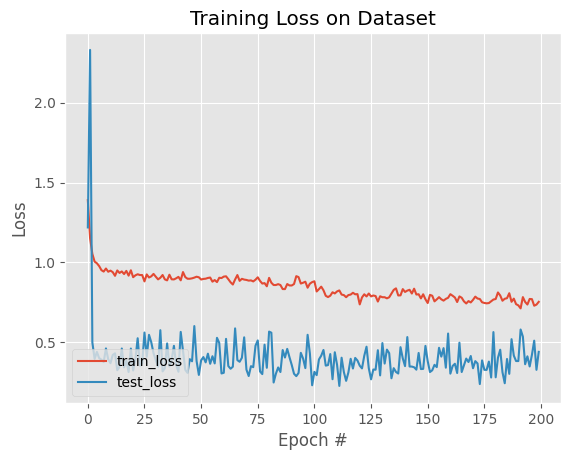

In [18]:
# plot the training/test loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss'], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')


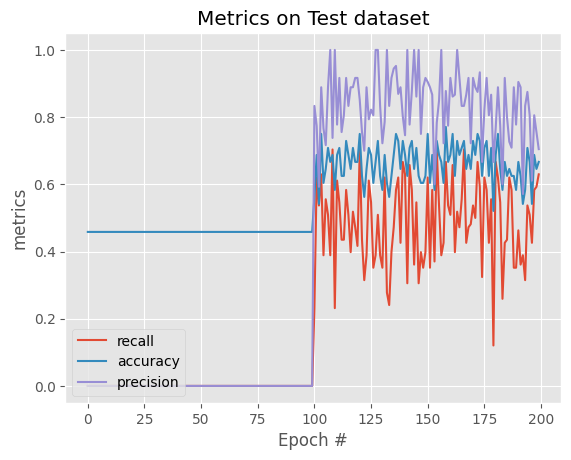

In [19]:
# plot the metrics
plt.style.use('ggplot')
plt.figure()
plt.plot(H['recall'], label='recall')
plt.plot(H['accuracy'], label='accuracy')
plt.plot(H['precision'], label='precision')
plt.title('Metrics on Test dataset')
plt.xlabel('Epoch #')
plt.ylabel('metrics')
plt.legend(loc='lower left')

# 4. Visualize predictions

In [20]:
def classify_image(path_image, path_model):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    image_initial = cv2.imread(path_image)
    image = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = np.transpose(image, (2, 0, 1)).astype('float32')
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)

    mask_real = cv2.imread(
        path_image.replace('images', 'masks').replace('jpg', 'png'), 0
    )
    class_label = int((np.sum(mask_real) > 0))

    unet = torch.load(path_model).cpu()
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        predicted_mask, pred_label = unet(image)
        predicted_mask = predicted_mask.squeeze()
        predicted_mask = torch.sigmoid(predicted_mask).numpy()
        # filter out the weak predictions and convert them to integers
        predicted_mask = predicted_mask.round()
        predicted_mask = predicted_mask.astype(np.uint8)
        predicted_mask = np.expand_dims(predicted_mask, 0)
        pred_label = int(torch.sigmoid(pred_label).round())

    # prepare a plot for visualization
    # pred_label = -1
    print(f'Prediction class {pred_label} - real class {class_label}')
    plt.figure(figsize=(16, 5))
    # image
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image_initial)
    # real mask
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Real mask')
    plt.imshow(mask_real)
    # predicted mask
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted mask')
    plt.imshow(predicted_mask[0])
    plt.show()

Prediction class 1 - real class 0


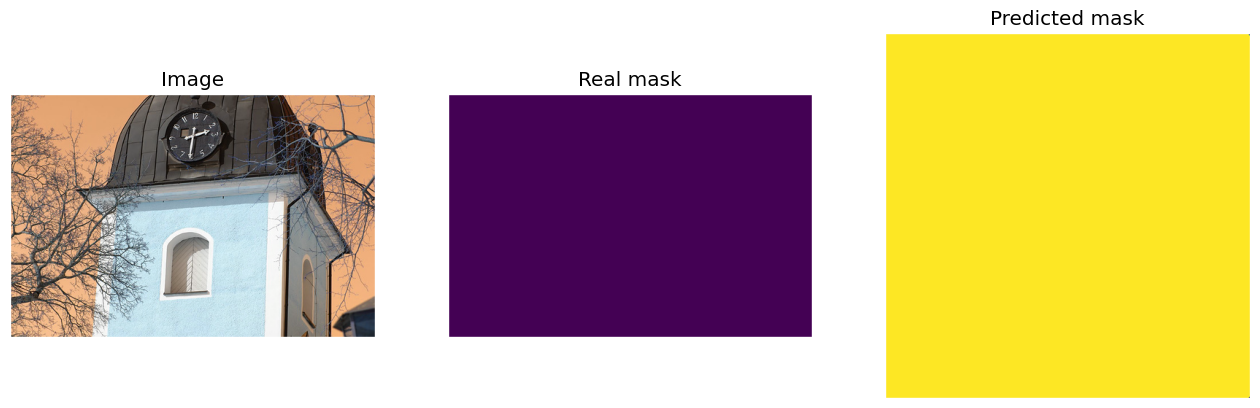

Prediction class 1 - real class 1


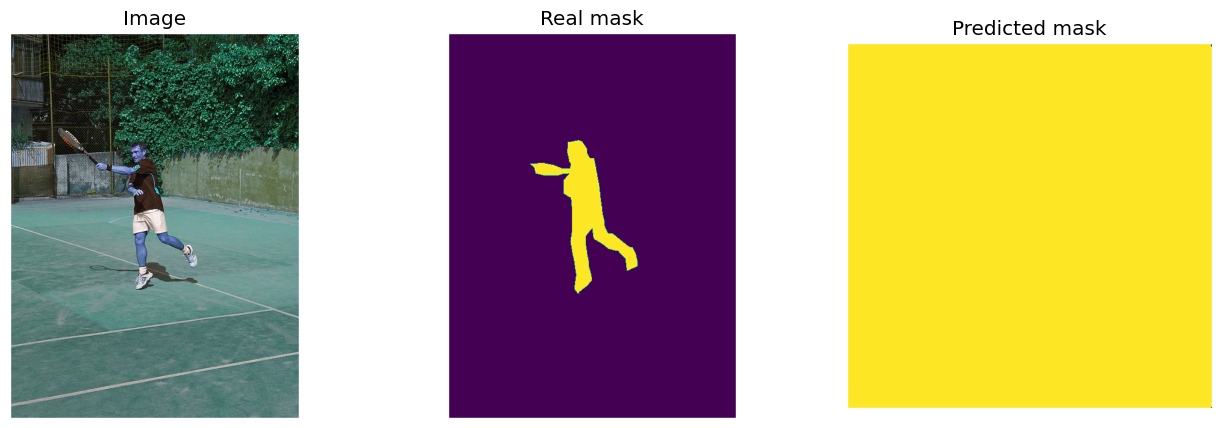

In [21]:
# no human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000009509.jpg'),
    path_model='unet_medpat.pt',
)

# human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000545525.jpg'),
    path_model='unet_medpat.pt',
)

Prediction class 1 - real class 1


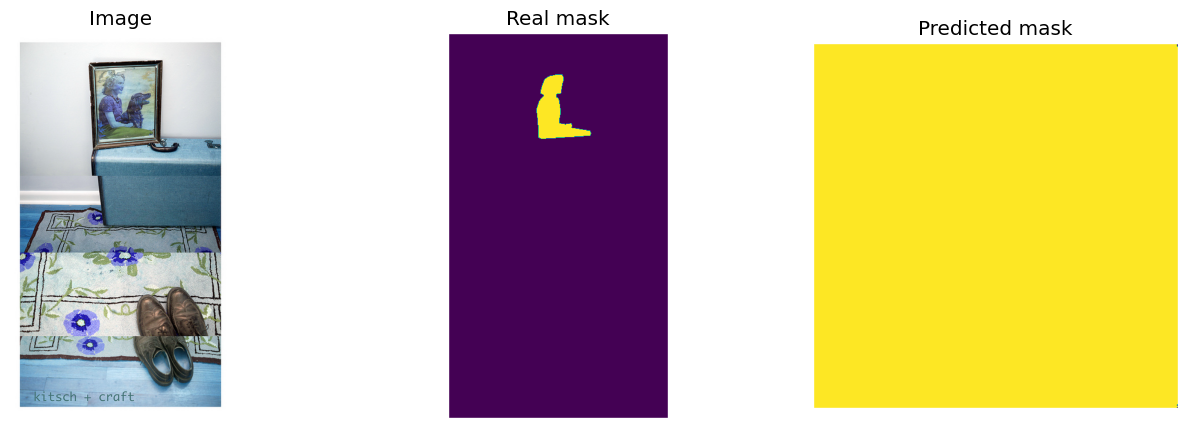

In [24]:
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000535650.jpg'),
    path_model='unet_medpat.pt',
)